# 读取 tfrecords 方法1（success）

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import sys
sys.path.append('../src/')
from util import data_utils
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
reader = tf.TFRecordReader()
filename_queue = tf.train.string_input_producer(['../../data/tfrecords/train/train_000.tfrecord'])
_, example_serialized = reader.read(filename_queue)

In [6]:
output_size = 224
trans_max = 20
scale_range = [0.8, 1.23]
def train_image_preprocessing(image, image_size, center, gt2d, pose=None, gt3d=None):
    margin = tf.to_int32(output_size / 2)
    with tf.name_scope(None, 'image_preprocessing', [image, center, gt2d]):
        keypoints = tf.transpose(gt2d[:, :])

        # Randomly shift center.
        print('Using translation jitter: %d' % trans_max)
        center = data_utils.jitter_center(center, trans_max)
        # randomly scale image.
        image, keypoints, center = data_utils.jitter_scale(
            image, image_size, keypoints, center, scale_range)

        # Pad image with safe margin.
        # Extra 50 for safety.
        margin_safe = margin + trans_max + 50
        image_pad = data_utils.pad_image_edge(image, margin_safe)
        center_pad = center + margin_safe
        keypoints_pad = keypoints + tf.to_float(margin_safe)
        start_pt = center_pad - margin

        # Crop image pad.
        start_pt = tf.squeeze(start_pt)
        bbox_begin = tf.stack([start_pt[1], start_pt[0], 0])
        bbox_size = tf.stack([output_size, output_size, 3])

        crop = tf.slice(image_pad, bbox_begin, bbox_size)
        x_crop = keypoints_pad[0, :] - tf.to_float(start_pt[0])
        y_crop = keypoints_pad[1, :] - tf.to_float(start_pt[1])

        crop_kp = tf.stack([x_crop, y_crop])

        if pose is not None:
            crop, crop_kp, new_pose, new_gt3d = data_utils.random_flip(    # TODO
                crop, crop_kp, pose, gt3d)
        else:
            crop, crop_kp = data_utils.random_flip(crop, crop_kp)

        # Normalize kp output to [-1, 1]
        final_label = 2.0 * (crop_kp / output_size) - 1.0

        # rescale image from [0, 1] to [-1, 1]
        crop = data_utils.rescale_image(crop)

        if pose is not None:
            return crop, tf.transpose(final_label), new_pose, new_gt3d
        else:
            return crop, tf.transpose(final_label)

In [7]:
feature_map = {
    'image': tf.FixedLenFeature([], dtype=tf.string, default_value=''),
    'image/center': tf.FixedLenFeature((2, 1), dtype=tf.int64),
    'image/filename': tf.FixedLenFeature([], dtype=tf.string, default_value=''),
    'image/height': tf.FixedLenFeature([1], dtype=tf.int64, default_value=-1),
    'image/width': tf.FixedLenFeature([1], dtype=tf.int64, default_value=-1),
    'label/seg': tf.FixedLenFeature([], dtype=tf.string, default_value=''),
    'label/pose': tf.FixedLenFeature((72,), dtype=tf.float32),
    'label/shape': tf.FixedLenFeature((10,), dtype=tf.float32),
    'label/gt2d': tf.FixedLenFeature((24 * 2,), dtype=tf.float32),
    'label/gt3d': tf.FixedLenFeature((24 * 3,), dtype=tf.float32),
}

features = tf.parse_single_example(example_serialized, feature_map)

height = tf.cast(features['image/height'], dtype=tf.int32)
width = tf.cast(features['image/width'], dtype=tf.int32)
center = tf.cast(features['image/center'], dtype=tf.int32)
fname = tf.cast(features['image/filename'], dtype=tf.string)
# fname = tf.Print(fname, [fname], message="image name: ")
image = data_utils.decode_jpeg(features['image'])
image_size = tf.concat([height, width], 0)
seg = tf.image.decode_png(features['label/seg'], channels=3)
pose = tf.cast(features['label/pose'], dtype=tf.float32)
shape = tf.cast(features['label/shape'], dtype=tf.float32)
gt2d = tf.reshape(tf.cast(features['label/gt2d'], dtype=tf.float32), [24, 2])
gt3d = tf.reshape(tf.cast(features['label/gt3d'], dtype=tf.float32), [24, 3])

image, gt2d = train_image_preprocessing(image, image_size, center, gt2d, pose=None, gt3d=None)

Using translation jitter: 20


In [9]:
sess = tf.InteractiveSession()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

(24, 2)


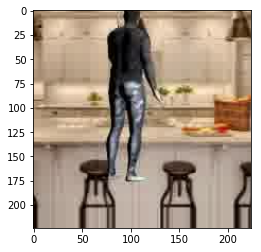

In [20]:
tf_image, tf_gt2d = sess.run([image, gt2d])
tf_image = (tf_image + 1) / 2
print(tf_gt2d.shape)
plt.imshow(tf_image)
plt.show()

# 读取 tfrecords 方法2（success）

In [1]:
import tensorflow as tf

In [6]:
sess = tf.Session()
tf_path = '/home/windward/gcy/dataset/Human3.6m/tf_records_human36m/tf_records_human36m_wjoints/train/h36m_train_mixed_1040.tfrecord'
all_images, all_centers, all_pose, all_shape, all_gt2d, all_gt3d = [], [], [], [], [], []
itr = 0
# Decode op graph
image_data_pl = tf.placeholder(dtype=tf.string)
decode_op = tf.image.decode_jpeg(image_data_pl)

for serialized_ex in tf.python_io.tf_record_iterator(tf_path):
    example = tf.train.Example()
    example.ParseFromString(serialized_ex)
    image_data = example.features.feature['image/encoded'].bytes_list.value[0]
    image = sess.run(decode_op, feed_dict={image_data_pl:  image_data})

    pose = example.features.feature['mosh/pose'].float_list.value
    shape = example.features.feature['mosh/shape'].float_list.value
    center = example.features.feature['image/center'].int64_list.value

    pose = np.array(pose).reshape((-1, 3))
    shape = np.array(shape)
    center = np.array(center)

#     gt2d = example.features.feature['gt2d'].float_list.value
#     gt2d = np.array(gt2d).reshape(-1, 2)
#     gt3d = example.features.feature['mosh/gt3d'].float_list.value
#     gt3d = np.array(gt3d).reshape(-1, 3)

    all_images.append(image)
    all_centers.append(center)
    all_pose.append(pose)
    all_shape.append(shape)
#     all_gt2d.append(gt2d)
#     all_gt3d.append(gt3d)

In [ ]:
all_images[0].mean()

In [7]:
len(all_images)

188

# 使用方法1读取 tf_records_human36m
训练集数量 300x1400+188=312188

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import sys
sys.path.append('../src/')
from util import data_utils
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
reader = tf.TFRecordReader()
filename_queue = tf.train.string_input_producer(
    ['/home/windward/gcy/dataset/Human3.6m/tf_records_human36m/tf_records_human36m_wjoints/train/h36m_train_mixed_0000.tfrecord'])
_, example_serialized = reader.read(filename_queue)

In [4]:
def parse_example_proto(example_serialized, has_3d=False):
    """Parses an Example proto.
    It's contents are:

        'image/height'       : _int64_feature(height),
        'image/width'        : _int64_feature(width),
        'image/x'            : _float_feature(label[0,:].astype(np.float)),
        'image/y'            : _float_feature(label[1,:].astype(np.float)),
        'image/visibility'   : _int64_feature(label[2,:].astype(np.int)),
        'image/format'       : _bytes_feature
        'image/filename'     : _bytes_feature
        'image/encoded'      : _bytes_feature
        'image/face_points'  : _float_feature,
         this is the 2D keypoints of the face points in coco 5*3 (x,y,vis) = 15

    if has_3d is on, it also has:
        'mosh/pose'          : float_feature(pose.astype(np.float)),
        'mosh/shape'         : float_feature(shape.astype(np.float)),
        # gt3d is 14x3
        'mosh/gt3d'          : float_feature(shape.astype(np.float)),
    """
    feature_map = {
        'image/encoded':
        tf.FixedLenFeature([], dtype=tf.string, default_value=''),
        'image/height':
        tf.FixedLenFeature([1], dtype=tf.int64, default_value=-1),
        'image/width':
        tf.FixedLenFeature([1], dtype=tf.int64, default_value=-1),
        'image/filename':
        tf.FixedLenFeature([], dtype=tf.string, default_value=''),
        'image/center':
        tf.FixedLenFeature((2, 1), dtype=tf.int64),
        'image/visibility':
        tf.FixedLenFeature((1, 14), dtype=tf.int64),
        'image/x':
        tf.FixedLenFeature((1, 14), dtype=tf.float32),
        'image/y':
        tf.FixedLenFeature((1, 14), dtype=tf.float32),
        'image/face_pts':
        tf.FixedLenFeature(
            (1, 15),
            dtype=tf.float32,
            default_value=[
                0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.
            ]),
    }
    if has_3d:
        feature_map.update({
            'mosh/pose':
            tf.FixedLenFeature((72, ), dtype=tf.float32),
            'mosh/shape':
            tf.FixedLenFeature((10, ), dtype=tf.float32),
            'mosh/gt3d':
            tf.FixedLenFeature((14 * 3, ), dtype=tf.float32),
            # has_3d is for pose and shape: 0 for mpi_inf_3dhp, 1 for h3.6m.
            'meta/has_3d':
            tf.FixedLenFeature((1), dtype=tf.int64, default_value=[0]),
        })

    features = tf.parse_single_example(example_serialized, feature_map)

    height = tf.cast(features['image/height'], dtype=tf.int32)
    width = tf.cast(features['image/width'], dtype=tf.int32)
    center = tf.cast(features['image/center'], dtype=tf.int32)
    fname = tf.cast(features['image/filename'], dtype=tf.string)
    fname = tf.Print(fname, [fname], message="image name: ")

    face_pts = tf.reshape(
        tf.cast(features['image/face_pts'], dtype=tf.float32), [3, 5])

    vis = tf.cast(features['image/visibility'], dtype=tf.float32)
    x = tf.cast(features['image/x'], dtype=tf.float32)
    y = tf.cast(features['image/y'], dtype=tf.float32)

    label = tf.concat([x, y, vis], 0)
    label = tf.concat([label, face_pts], 1)

    image = data_utils.decode_jpeg(features['image/encoded'])
    image_size = tf.concat([height, width], 0)

    if has_3d:
        pose = tf.cast(features['mosh/pose'], dtype=tf.float32)
        shape = tf.cast(features['mosh/shape'], dtype=tf.float32)
        gt3d = tf.reshape(
            tf.cast(features['mosh/gt3d'], dtype=tf.float32), [14, 3])
        has_smpl3d = tf.cast(features['meta/has_3d'], dtype=tf.bool)
        return image, image_size, label, center, fname, pose, shape, gt3d, has_smpl3d
    else:
        return image, image_size, label, center, fname

In [5]:
_image, _image_size, _label, _center, _fname, _pose, _shape, _gt3d, _has_smpl3d = parse_example_proto(
    example_serialized, has_3d=True)

In [6]:
sess = tf.InteractiveSession()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

In [7]:
image, image_size, label, center, fname, pose, shape, gt3d, has_smpl3d = sess.run(
    [_image, _image_size, _label, _center, _fname, _pose, _shape, _gt3d, _has_smpl3d])

In [8]:
print(image.shape, image.max(), image.min())

(300, 300, 3) 1.0 0.0


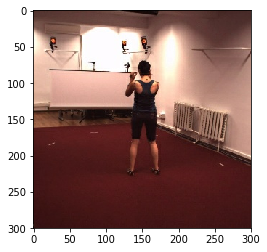

In [9]:
plt.imshow(image)
plt.show()

In [10]:
label.shape

(3, 19)

In [11]:
pose.shape

(72,)

In [12]:
shape.shape

(10,)

In [13]:
gt3d.shape

(14, 3)

In [39]:
fname

'frame0180.png'

In [16]:
import numpy as np
from glob import glob
from opendr.renderer import ColoredRenderer
from opendr.lighting import LambertianPointLight
from opendr.camera import ProjectPoints
import sys, os
sys.path.append("/home/windward/gcy/Golf/SMPL/smpl/")
from smpl_webuser.serialization import load_model
import json
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def render(rn, m):
    # Assign attributes to renderer
    w, h = (320, 240)
    rn.camera = ProjectPoints(v=m, rt=np.zeros(3), t=np.array([0, 0, 2.]), f=np.array([w, w])/2., 
                              c=np.array([w, h])/2., k=np.zeros(5))
    rn.frustum = {'near': 1., 'far': 10., 'width': w, 'height': h}
    rn.set(v=m, f=m.f, bgcolor=np.zeros(3))
    # Construct point light source
    rn.vc = LambertianPointLight(
        f=m.f,
        v=rn.v,
        num_verts=len(m),
        light_pos=np.array([-1000, -1000, -2000]),
        vc=np.ones_like(m)*.9,
        light_color=np.array([1., 1., 1.]))
    return rn

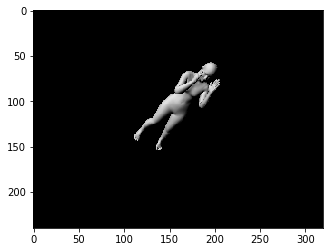

In [38]:
m = load_model('/home/windward/gcy/Golf/SMPL/smpl/models/basicModel_f_lbs_10_207_0_v1.0.0.pkl')
rn = ColoredRenderer()
m.pose[:] = pose
m.pose[0] = np.pi * 3
m.betas[:] = shape
rn = render(rn, m)
plt.imshow(rn.r)
plt.show()